In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import r2_score

In [3]:
df = pd.read_csv('bmw.csv')
df

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0
...,...,...,...,...,...,...,...,...,...
10776,X3,2016,19000,Automatic,40818,Diesel,150,54.3,2.0
10777,5 Series,2016,14600,Automatic,42947,Diesel,125,60.1,2.0
10778,3 Series,2017,13100,Manual,25468,Petrol,200,42.8,2.0
10779,1 Series,2014,9930,Automatic,45000,Diesel,30,64.2,2.0


In [6]:
# Предобработка данных
df.dropna(inplace=True)
df = pd.get_dummies(df, drop_first=True)

In [7]:
# Кодирование категориальных признаков
df = pd.get_dummies(df, drop_first=True)

# Разделение данных на признаки и целевую переменную
X = df.drop(columns=['price'])
y = df['price']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Прогнозирование и оценка
y_pred_rf = rf_model.predict(X_test)
rf_r2 = r2_score(y_test, y_pred_rf)
print(f'R2 Score: {rf_r2:.4f}')

R2 Score: 0.9425


При результате 0,94 модель хорошо объясняет все вариации зависимой переменной. Идеальным результатом считается 1.

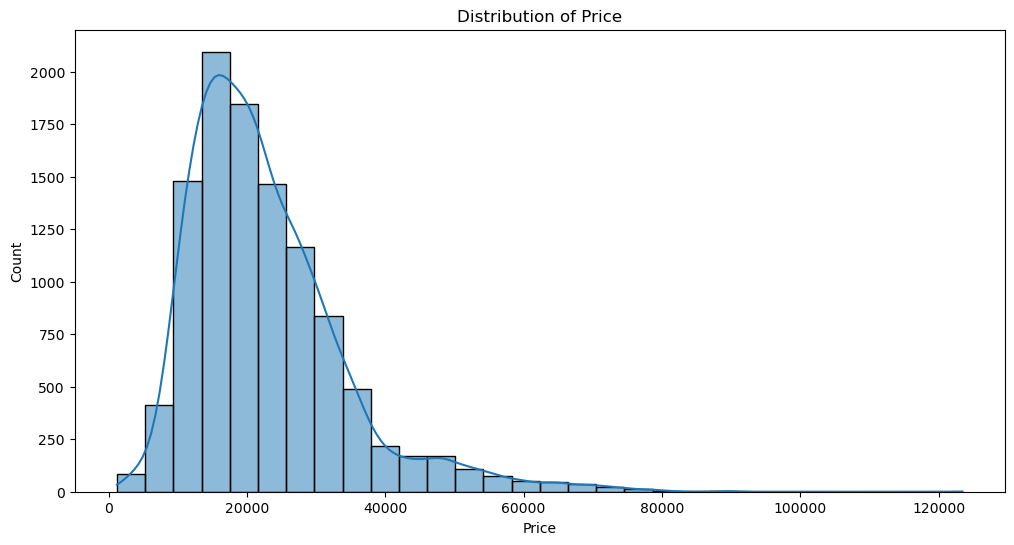

In [13]:
# Проверка данных на выбросы и распределение
plt.figure(figsize=(12, 6))
sns.histplot(y, kde=True, bins=30)
plt.xlabel('Price')
plt.title('Distribution of Price')
plt.show()

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
param_grid_sgd = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
    'max_iter': [1000, 2000, 3000, 5000],
    'penalty': ['l2', 'l1', 'elasticnet']
}
sgd = SGDRegressor(random_state=42)
grid_search_sgd = GridSearchCV(sgd, param_grid_sgd, cv=5, scoring='r2')
grid_search_sgd.fit(X_train_scaled, y_train)
best_sgd = grid_search_sgd.best_estimator_

# Прогнозирование и оценка
y_pred_sgd = best_sgd.predict(X_test_scaled)
sgd_r2 = r2_score(y_test, y_pred_sgd)
print(f'SGD Regressor R2 Score: {sgd_r2:.4f}')
print(f'Best SGD Parameters: {grid_search_sgd.best_params_}')

SGD Regressor R2 Score: 0.7433
Best SGD Parameters: {'alpha': 1, 'max_iter': 1000, 'penalty': 'elasticnet'}


Результат 0,7433 означает, что модель объясняет 74.33% вариации зависимой переменной (в моем случае стоимость машины) с помощью независимых переменных

In [23]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=3, scoring='r2')
grid_search_rf.fit(X_train_scaled, y_train)
best_rf = grid_search_rf.best_estimator_
print(f'Best Random Forest Parameters: {grid_search_rf.best_params_}')

Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


max_depth none означает, что глубина каждого дерева в лесу не ограничена. Деревья будут расти до тех пор, пока все листья не станут чистыми.
Это позволяет каждому дереву захватывать максимум информации из данных, что может привести к высокой точности, но также увеличивает риск переобучения.
min_samples_leaf - минимальное количество выборок, необходимых чтобы лист содержал как минимум одну выборку
min_

In [22]:
# Оценка качества модели случайного леса
rf_cv_scores = cross_val_score(best_rf, X, y, cv=3, scoring='r2')
print(f'Random Forest Cross-Validation R2 Scores: {rf_cv_scores}')
print(f'Random Forest Cross-Validation R2 Mean: {np.mean(rf_cv_scores):.4f}')

Random Forest Cross-Validation R2 Scores: [0.93296008 0.90377252 0.79182056]
Random Forest Cross-Validation R2 Mean: 0.8762


Значение R2 является хорошим, тк модель объясняет большинство вариаций цены машины

                   Feature    Importance
0                     year  4.559112e-01
4               engineSize  2.689281e-01
3                      mpg  8.553573e-02
1                  mileage  6.081573e-02
27               model_ i8  1.731571e-02
28     transmission_Manual  1.567325e-02
21               model_ X5  1.470630e-02
23               model_ X7  1.274430e-02
2                      tax  9.004901e-03
11         model_ 8 Series  8.383676e-03
19               model_ X3  7.819843e-03
10         model_ 7 Series  7.455488e-03
22               model_ X6  5.931423e-03
5          model_ 2 Series  5.615885e-03
8          model_ 5 Series  4.568215e-03
33         fuelType_Petrol  3.505448e-03
31         fuelType_Hybrid  2.541394e-03
7          model_ 4 Series  2.329426e-03
20               model_ X4  2.080671e-03
29  transmission_Semi-Auto  1.960843e-03
6          model_ 3 Series  1.629283e-03
17               model_ X1  1.586083e-03
14               model_ M4  9.253442e-04
9          model

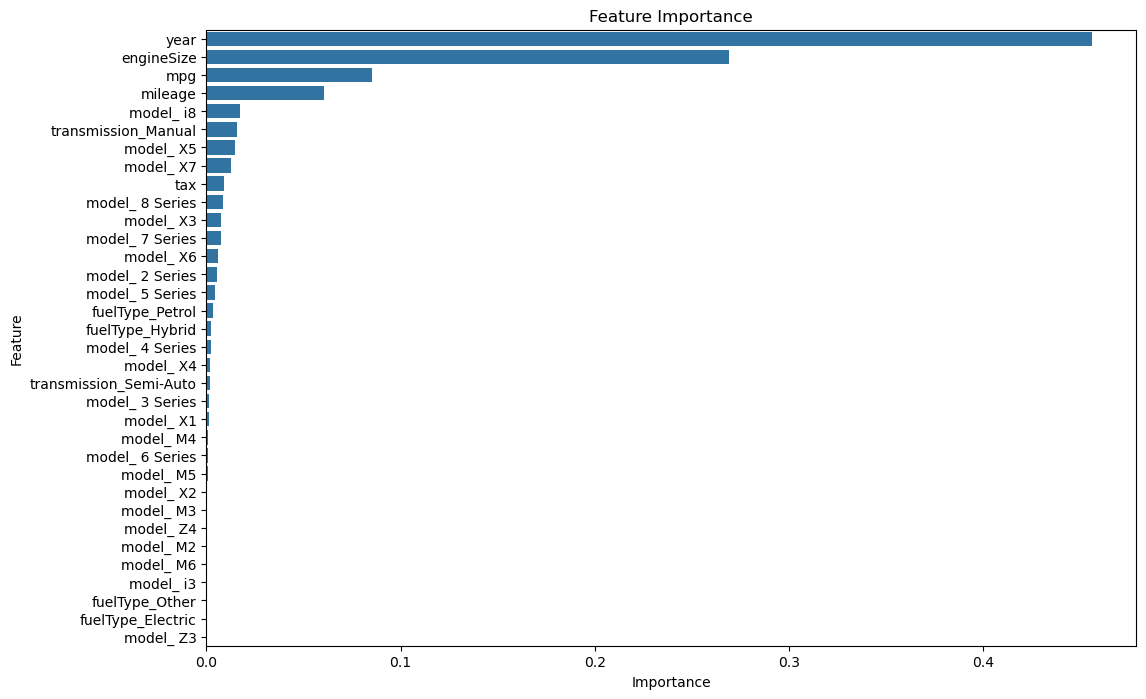

In [24]:
# Важность признаков для случайного леса
feature_importances = best_rf.feature_importances_
features = X.columns
importances = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importances = importances.sort_values(by='Importance', ascending=False)
print(importances)

# Визуализация важности признаков
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importances)
plt.title('Feature Importance')
plt.show()

Как мы видим, год машины влияет на цену сильнее всех других признаков, размер двигателя так же важен. MPG и пробег важны, но не сильно вляют на цену. Остальные же признаки, почти не учитываются

Задание из Normal: Построить модель стекинга над всеми моделями из предыдущей задачи. Добавить в стекинг один из градиентных бустингов XGBoost/LightGBM/CatBoost.


In [28]:
from xgboost import XGBRegressor

In [29]:
# Обучение моделей
sgd_model = SGDRegressor(alpha=1, max_iter=1000, penalty='elasticnet', random_state=42)
rf_model = RandomForestRegressor(max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200, random_state=42)
xgb_model = XGBRegressor(n_estimators=200, random_state=42)

In [33]:
estimators = [
    ('sgd', sgd_model),
    ('rf', rf_model),
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=xgb_model
)
stacking_model.fit(X_train_scaled, y_train)

StackingRegressor(estimators=[('sgd',
                               SGDRegressor(alpha=1, penalty='elasticnet',
                                            random_state=42)),
                              ('rf',
                               RandomForestRegressor(min_samples_split=5,
                                                     n_estimators=200,
                                                     random_state=42))],
                  final_estimator=XGBRegressor(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               device=None,
                                               early_stopping_ro...
                                               feature_types=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=None, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None,
                                               max_depth=None, max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=200, n_jobs=None,
                                               num_parallel_tree=None,
                                               random_state=42, ...))

In [35]:
# Прогнозирование и оценка стекинговой модели
y_pred_stacking = stacking_model.predict(X_test_scaled)
stacking_r2 = r2_score(y_test, y_pred_stacking)
print(f'Stacking Regressor R2 Score: {stacking_r2:.4f}')

Stacking Regressor R2 Score: 0.9325


In [36]:
stacking_cv_scores = cross_val_score(stacking_model, X, y, cv=5, scoring='r2')
print(f'Staking Regressor Cross-Validation R2 Scores: {stacking_cv_scores}')
print(f'Staking Regressor Cross-Validation R2 Mean: {np.mean(stacking_cv_scores):.4f}')

Staking Regressor Cross-Validation R2 Scores: [0.88796376 0.82919983 0.90490856 0.91414473 0.89673508]
Staking Regressor Cross-Validation R2 Mean: 0.8866
